<a href="https://colab.research.google.com/github/pop-ketle/Fish-Chaser/blob/main/generate_blending_img.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 雲のノイズを除去するモデルを作成したい。
それには雲のノイズが乗った画像を入力、乗っていない画像を出力としたAutoencoderを作成することを目指す。

In [43]:
import os
import sys
import cv2
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from collections import deque
from matplotlib import pyplot as plt
from IPython.display import clear_output

if 'google.colab' in sys.modules:
    !pip install japanize-matplotlib
    import japanize_matplotlib

clear_output()

## データの作成

In [44]:
RANDOM_SEED = 72 # seedの固定
SIZE_W = 512
SIZE_H = 512

In [45]:
DATA_DIR = Path('/content/drive/MyDrive/uploda/Fish_Chaser/datasets/raw/satellite_images')

# NOTE: ちょっと書き方汚いけど、手っ取り早いので...
years = [str(y) for y in range(2010, 2020+1)]
months = [str(m).zfill(2) for m in range(1, 12+1)]
days = [str(d).zfill(2) for d in range(1, 31+1)]

ls = []
for year in years:
    for month in months:
        for day in days:
            path_7Dc = str((DATA_DIR / f'{year}/7Dc/7Dc_{year}{month}{day}0000.png')) # opencvでpathlib使えないらしいので
            path_7Wc = str((DATA_DIR / f'{year}/7Wc/7Wc_{year}{month}{day}0000.png'))
            if not os.path.isfile(path_7Dc): path_7Dc = None
            if not os.path.isfile(path_7Wc): path_7Wc = None
            
            ls.append([year, month, day, path_7Dc, path_7Wc])
data = pd.DataFrame(ls, columns=['year', 'month', 'day', 'path_7Dc', 'path_7Wc'])
print(data.isnull().sum()) # 欠損値確認

data

year          0
month         0
day           0
path_7Dc    141
path_7Wc    196
dtype: int64


,year,month,day,path_7Dc,path_7Wc
0,2010,01,01,/content/drive/MyDrive/uploda/Fish_Chaser/data...,/content/drive/MyDrive/uploda/Fish_Chaser/data...
1,2010,01,02,/content/drive/MyDrive/uploda/Fish_Chaser/data...,/content/drive/MyDrive/uploda/Fish_Chaser/data...
2,2010,01,03,/content/drive/MyDrive/uploda/Fish_Chaser/data...,/content/drive/MyDrive/uploda/Fish_Chaser/data...
3,2010,01,04,/content/drive/MyDrive/uploda/Fish_Chaser/data...,/content/drive/MyDrive/uploda/Fish_Chaser/data...
4,2010,01,05,/content/drive/MyDrive/uploda/Fish_Chaser/data...,/content/drive/MyDrive/uploda/Fish_Chaser/data...
...,...,...,...,...,...
4087,2020,12,27,/content/drive/MyDrive/uploda/Fish_Chaser/data...,None
4088,2020,12,28,/content/drive/MyDrive/uploda/Fish_Chaser/data...,None
4089,2020,12,29,/content/drive/MyDrive/uploda/Fish_Chaser/data...,None
4090,2020,12,30,/content/drive/MyDrive/uploda/Fish_Chaser/data...,None


---

## 案1
np.random.normal()によるノイズを入れて雲のノイズとして扱う

### 実験

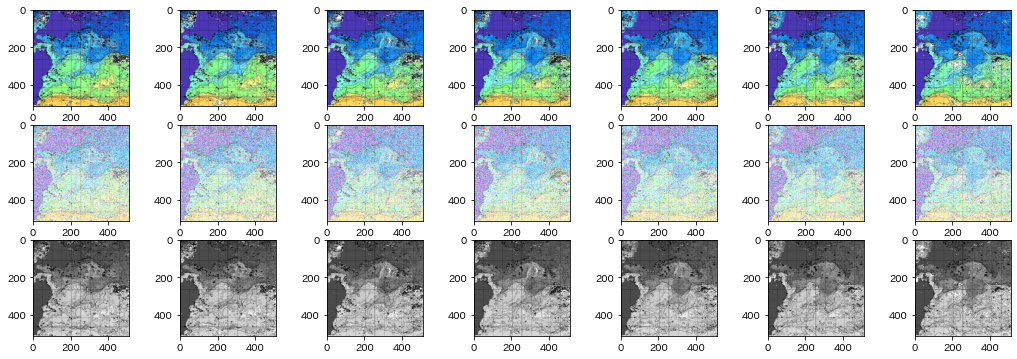

In [46]:
# 画像を可視化
# 新規ウインドウ作成
fig = plt.figure(figsize=(18, 6))
x, y = 3, 7

for i, idx in enumerate([0,1,2,3,4,5,6]):
    i = i+1
    img = cv2.imread(data.iloc[idx]['path_7Wc'], cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (SIZE_W, SIZE_H))

    ax1 = fig.add_subplot(x, y, i)
    plt.imshow(img)
    
    img = cv2.imread(data.iloc[idx]['path_7Wc'], cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (SIZE_W, SIZE_H))
    # noise追加
    noise = np.random.normal(0, 150, img.shape)
    img = img + np.floor(noise)

    ax1 = fig.add_subplot(x, y, i+7)
    plt.imshow(img)

    img = cv2.imread(data.iloc[idx]['path_7Wc'], cv2.IMREAD_GRAYSCALE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (SIZE_W, SIZE_H))
    
    ax1 = fig.add_subplot(x, y, i+14)
    plt.imshow(img)

clear_output()
plt.show()

この実験結果を見る限り、雲ノイズとして役に立ちそうではない。上手くいかなさそうなのでこの案はやめる。


---

## 案2

7Dc(1日合成最新画像)を当日から7日後までの画像を合成して保存する

2010 - 2020年までに141個欠損値があるので、その分は飛ばすこととする。

```
例:
2011/10/1 - 2011/10/7 の間で画像が1枚足りない場合、6枚で合成する。
2011/10/1 - 2011/10/7 の間で2011/10/1の画像がない場合、合成は行わない。
```

### 実験

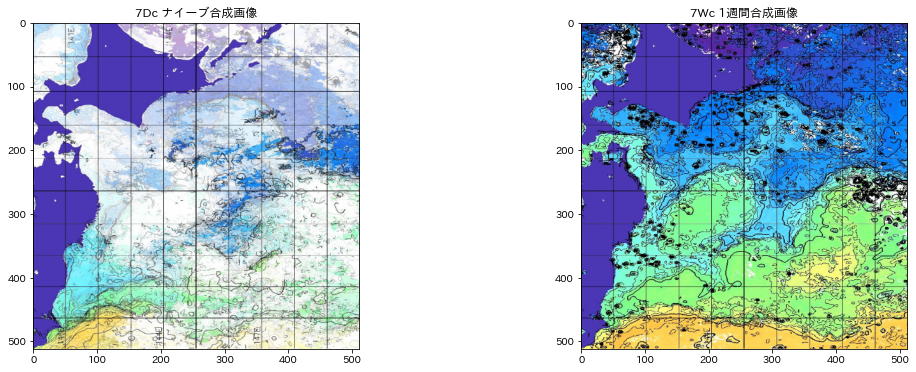

In [47]:
fig = plt.figure(figsize=(18, 6))
x, y = 1, 2

# 7日間の画像をナイーブに合成する
imgs = []
for idx in [0,1,2,3,4,5,6]:
    img = cv2.imread(data.iloc[idx]['path_7Dc'], cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (SIZE_W, SIZE_H))
    imgs.append(img)

blend = imgs[0]
for img in imgs[1:]:
    blend = cv2.addWeighted(blend, 0.5, img, 0.5, 0)
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('7Dc ナイーブ合成画像')
plt.imshow(blend)

# 7Wc(1週間合成画像)として、いわて大漁ナビのなんらかの処理を加えてノイズ除去を行った画像を読み込む
path = '/content/drive/MyDrive/uploda/Fish_Chaser/datasets/raw/satellite_images/2010/7Wc/7Wc_201001010000.png'
img = cv2.imread(path, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (SIZE_W, SIZE_H))
ax1 = fig.add_subplot(1, 2, 2)
ax1.set_title('7Wc 1週間合成画像')
plt.imshow(img)

plt.show()

この結果より、上手くいく可能性があるのではないかと考えた。

---

# 実際に生成して保存する
画像のクラス名は'7Ad'とする。

In [49]:
# 両端の追加削除はdepueが速いのでこちらを使う
img_paths = deque()
for file_path in tqdm(data['path_7Dc'].values, total=len(data['path_7Dc'].values)):
    img_paths.append(file_path)

    if len(img_paths)==7:
        # NOTE: かなり効率悪いけど...
        seed_path = img_paths.popleft()
        if seed_path == None: continue # 元の画像がない場合、合成は行わない

        # 7日間の画像の合成
        blend = cv2.imread(seed_path, cv2.IMREAD_COLOR)
        for img_path in img_paths:
            if img_path == None: continue # 画像がない場合、その画像は飛ばす
            
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            blend = cv2.addWeighted(blend, 0.5, img, 0.5, 0)
        blend = cv2.resize(blend, (SIZE_W, SIZE_H))

        # 合成画像の保存
        out_path = seed_path.replace('7Dc', '7Ad')
        out_dir, out_filename =  os.path.split(out_path)

        os.makedirs(out_dir, exist_ok=True)
        cv2.imwrite(out_path, blend) 

100%|██████████| 4092/4092 [15:14<00:00,  4.47it/s]
